# UNSW2018_extractor_train

Fold 1
Fold 1 - Accuracy: 99.80%, Precision: 99.80%, Recall: 99.80%, F1: 99.79%, Kappa: 99.75%
Train_time: 449.93s, Test_time: 6.805s, Memory: 248.30MB
Fold 2
Fold 2 - Accuracy: 99.76%, Precision: 99.74%, Recall: 99.76%, F1: 99.75%, Kappa: 99.70%
Train_time: 438.49s, Test_time: 5.002s, Memory: 231.51MB
Fold 3
Fold 3 - Accuracy: 99.78%, Precision: 99.76%, Recall: 99.78%, F1: 99.76%, Kappa: 99.72%
Train_time: 436.94s, Test_time: 4.930s, Memory: 192.25MB
Fold 4
Fold 4 - Accuracy: 99.84%, Precision: 99.82%, Recall: 99.84%, F1: 99.83%, Kappa: 99.80%
Train_time: 438.04s, Test_time: 5.018s, Memory: 239.19MB
Fold 5
Fold 5 - Accuracy: 99.82%, Precision: 99.80%, Recall: 99.82%, F1: 99.80%, Kappa: 99.77%
Train_time: 439.32s, Test_time: 4.968s, Memory: 268.19MB
Fold 6
Fold 6 - Accuracy: 99.71%, Precision: 99.63%, Recall: 99.71%, F1: 99.67%, Kappa: 99.64%
Train_time: 438.09s, Test_time: 5.019s, Memory: 215.25MB
Fold 7
Fold 7 - Accuracy: 99.69%, Precision: 99.70%, Recall: 99.69%, F1: 99.69%, Kappa: 

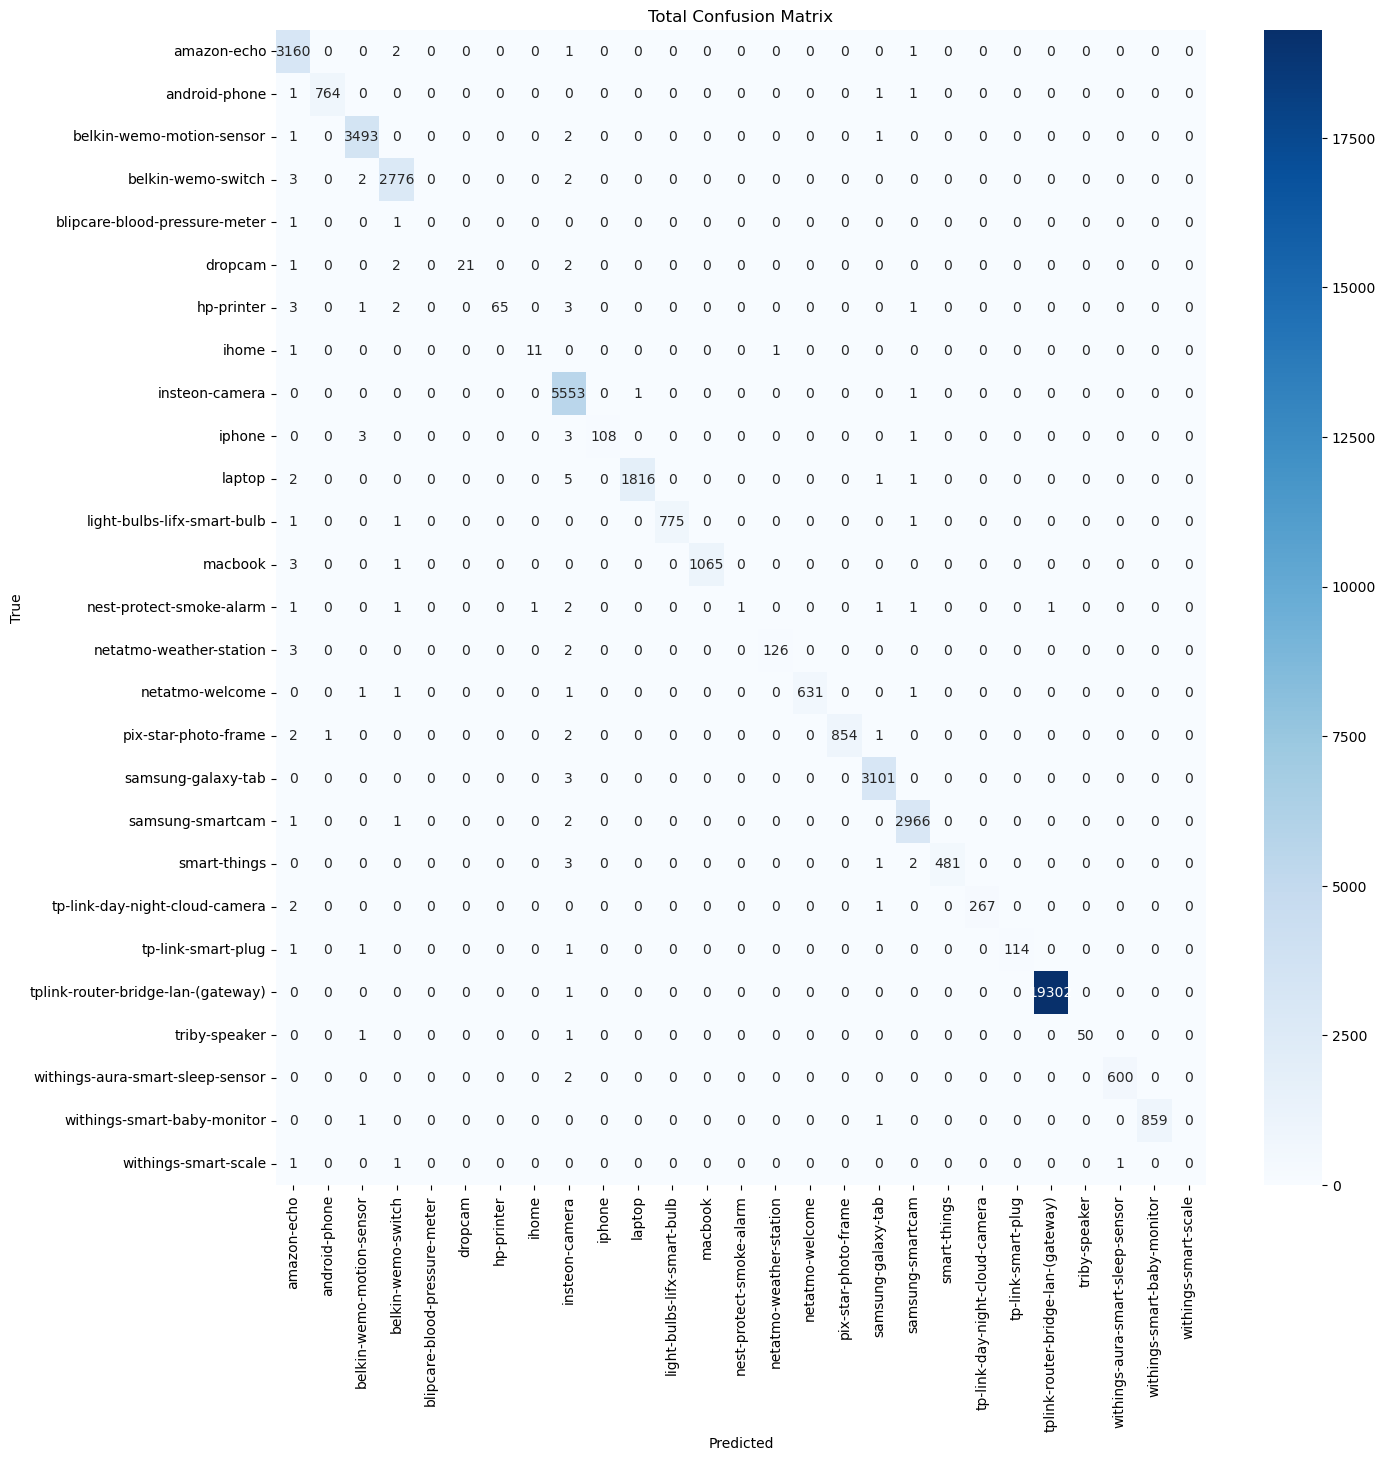

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


data = 'UNSW2018/4image_final'
model_dir = './UNSW2018/model' 
os.makedirs(model_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.ImageFolder(root=data, transform=transform)

#Design feature extractor (LeNet-5)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.noise = nn.Parameter(torch.randn(84)) 

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = nn.ReLU()(self.fc1(out))
        out = self.fc2(out) + self.noise  # Bottleneck layer and feature confusion
        return out


class PairedClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=27):
        super(PairedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 84)
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = nn.ReLU()(self.fc1(x))
        out = self.fc2(out)
        return out


class AdversarialClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=27):
        super(AdversarialClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 84)
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = nn.ReLU()(self.fc1(x))
        out = self.fc2(out)
        return out


criterion = nn.CrossEntropyLoss()


def joint_loss(paired_outputs, adversarial_outputs, labels, criterion, alpha=0.5, beta=0.1, gamma=0.202):
    paired_loss = criterion(paired_outputs, labels)
    adversarial_loss = -criterion(adversarial_outputs, labels)
    cooperative_loss = torch.mean((paired_outputs - adversarial_outputs) ** 2)  # Collaborative loss
    loss = alpha * paired_loss + beta * adversarial_loss + gamma * cooperative_loss
    return loss


def add_fgsm_noise(inputs, model, criterion, labels, epsilon=0.1):
    inputs.requires_grad = True
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    data_grad = inputs.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_image = inputs + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


def evaluate_model(feature_extractor, classifier, loader, fold):
    feature_extractor.eval()
    classifier.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            features = feature_extractor(images)
            outputs = classifier(features)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    
    labels_list = list(range(len(dataset.classes)))  

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds, labels=labels_list)  
    
    """if not os.path.exists('confusion_matrix'):
        os.makedirs('confusion_matrix')
    
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.savefig(f'UNSW2018/confusion_matrix/confusion_matrix_fold_{fold}.pdf')
    plt.show()
    plt.close()"""
    
    return accuracy, precision, recall, f1, kappa, cm

def adjust_params_and_train(criterion, epochs, epsilon, alpha, beta, gamma):
    # 10 fold cross validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold = 0
    accuracies = []
    f1_scores = []
    precisions = []
    recalls = []
    kappas = []
    total_cm = np.zeros((len(dataset.classes), len(dataset.classes)), dtype=int)

    for train_index, test_index in kf.split(dataset):
        fold += 1
        print(f'Fold {fold}')

        train_subset = Subset(dataset, train_index)
        test_subset = Subset(dataset, test_index)

        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

        
        feature_extractor = FeatureExtractor().to(device)
        input_dim = 84  # Output dimension of feature extractor
        paired_classifier = PairedClassifier(input_dim=input_dim, num_classes=len(dataset.classes)).to(device)
        adversarial_classifier = AdversarialClassifier(input_dim=input_dim, num_classes=len(dataset.classes)).to(device)

        fe_optimizer = optim.Adam(feature_extractor.parameters(), lr=0.001)
        pc_optimizer = optim.Adam(paired_classifier.parameters(), lr=0.001)
        ac_optimizer = optim.Adam(adversarial_classifier.parameters(), lr=0.001)

        # Record training time and memory
        start_time = time.time()
        process = psutil.Process(os.getpid())
        start_memory = process.memory_info().rss / (1024 * 1024)

        # training process
        for epoch in range(epochs):
            feature_extractor.train()
            paired_classifier.train()
            adversarial_classifier.train()

            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Extract features and add adversarial perturbations
                adv_images = add_fgsm_noise(images, feature_extractor, criterion, labels, epsilon=epsilon).to(device)
                features = feature_extractor(images)
                adv_features = feature_extractor(adv_images)

                # Calculate the outputs of the matching classifier and adversarial classifier
                paired_outputs = paired_classifier(features)
                adversarial_outputs = adversarial_classifier(adv_features)

                # Calculate joint losses
                loss = joint_loss(paired_outputs, adversarial_outputs, labels, criterion, alpha, beta, gamma)

                fe_optimizer.zero_grad()
                pc_optimizer.zero_grad()
                ac_optimizer.zero_grad()
                loss.backward()
                fe_optimizer.step()
                pc_optimizer.step()
                ac_optimizer.step()

        end_time = time.time()
        end_memory = process.memory_info().rss /(1024 * 1024)

        training_time = end_time - start_time
        memory_usage = end_memory - start_memory

        start_time = time.time()
        pc_accuracy, pc_precision, pc_recall, pc_f1, pc_kappa, cm = evaluate_model(feature_extractor, paired_classifier, test_loader, fold)
        end_time = time.time()
        testing_time = end_time - start_time

        total_cm += cm

        print(f'Fold {fold} - Accuracy: {pc_accuracy * 100:.2f}%, Precision: {pc_precision * 100:.2f}%, Recall: {pc_recall * 100:.2f}%, F1: {pc_f1 * 100:.2f}%, Kappa: {pc_kappa * 100:.2f}%')
        print(f'Train_time: {training_time:.2f}s, Test_time: {testing_time:.3f}s, Memory: {memory_usage:.2f}MB')

        accuracies.append(pc_accuracy)
        precisions.append(pc_precision)
        recalls.append(pc_recall)
        f1_scores.append(pc_f1)
        kappas.append(pc_kappa)

    # Calculate the average accuracy and F1 score
    mean_accuracy = np.mean(accuracies)
    mean_f1_score = np.mean(f1_scores)
    mean_precision = np.mean(precisions)
    mean_kappa = np.mean(kappas)
    mean_recall = np.mean(recalls)
    std_accuracy = np.std(accuracies)
    std_f1_score = np.std(f1_scores)

    # Save the final model and features
    torch.save(feature_extractor.state_dict(), os.path.join(model_dir, 'feature_extractor_UNSW2018.pth'))

    print(f'Average accuracy: {mean_accuracy * 100:.2f}% ± {std_accuracy * 100:.2f}%')
    print(f'average F1: {mean_f1_score:.2f} ± {std_f1_score:.2f}')
    print(f'Precision: {mean_precision * 100:.2f}%')
    print(f'Recall: {mean_recall * 100:.2f}%')
    print(f'Kappa: {mean_kappa * 100:.2f}%')

    #creat dir
    if not os.path.exists('UNSW2018/confusion_matrix'):
        os.makedirs('UNSW2018/confusion_matrix')
        
    #Calculate the confusion matrix as percentages
    #total_cm = total_cm.astype('float') / total_cm.sum(axis=1)[:, np.newaxis]

    # Draw and save the overall confusion matrix
    plt.figure(figsize=(15, 15))
    sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Total Confusion Matrix')
    plt.savefig('UNSW2018/confusion_matrix/confusion_Metrix.pdf')
    plt.show()
    plt.close()

#Adjusting parameters and training functions for adversarial training
adjust_params_and_train(
    criterion,
    epochs=15,
    epsilon=0.1,
    alpha=0.50,
    beta=0.1,
    gamma=0.202
)
